# Using GPU Optical Flow Filter in Python

This notebook illustrates how to use the GPU implementation of the optical flow filter in Python.

## 1. Installation

Please follow the installation instructions provided in the **README.md** file in the [GitHub]( https://github.com/jadarve/optical-flow-filter) repository to install the C++ library and Python modules.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.misc as misc
import scipy.ndimage as ndimage

import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt

import flowfilter.plot as fplot
import flowfilter.gpu.flowfilters as gpufilter

import cv2

import copy

## 2. Error performance

The following piece computes optical flow using a **PyramidalFlowFilter** filter object. The filter is configured to 2 image pyramid levels and maximum optical flow of 4 pixels. [2, 4] smooth iterations are performed for at each pyramid level.

The computed flow is compared to ground truth data produced for this sequence using Blender.

In [3]:
# paths to image and ground truth data
basepath = '/media/cedric/storage_ext4/data/DJI/DJI_forest_3/DJI_f3_processing/d4/img/' 
imgpath = basepath + '{0:04d}.png'
# gtpath = basepath + 'of_{0:04d}.npy'

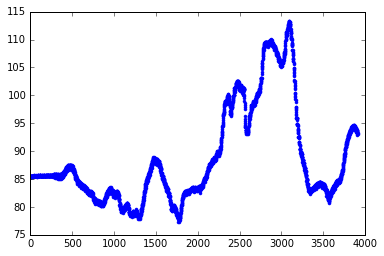

In [4]:
# correct brightness
offset = 1
K = 3911
mean_int = []
for k in range(offset, offset + K):
    
    img_g = cv2.imread(imgpath.format(k), 0)
    mean_int.append(np.mean(img_g))
    
mean_int_temp = copy.deepcopy(mean_int)

bad_inds = []
for i in range(1,len(mean_int_temp)):
    if np.abs(mean_int_temp[i] - mean_int_temp[i - 1]) > 1.4:
        bad_inds.append(i + 1)
        mean_int_temp[i] = mean_int_temp[i - 1]
        
plt.plot(range(0,len(mean_int_temp)), mean_int_temp, '.')
plt.show()
    


In [5]:
blur_toggle = False
# GPU filter object with 2 pyramid levels

# set image resolution
image1 = np.array([480, 640])
res_DJI = np.array([720, 1280])
low_res_DJI = np.array([360, 640])
# imdim = image1
imdim = res_DJI

gpuF = gpufilter.PyramidalFlowFilter(imdim[0], imdim[1], 3)
gpuF.gamma = [20, 20, 50]                                   # gains for each level
gpuF.maxflow = 8.0                                      # maximum optical flow value
gpuF.smoothIterations = [2, 2, 4]                          # smooth iterations per level

# print('maxflow: {0}'.format(gpuF.maxflow))

avgET = np.zeros(K)

inds = [i for i in range(offset, offset + K)]

for i in bad_inds:
    inds.remove(i)
# idea is to remove file and copy previous frame :P

bad_inds


[2026,
 2027,
 2028,
 2430,
 2431,
 2432,
 2759,
 2760,
 2761,
 2762,
 2763,
 3023,
 3024,
 3025,
 3528,
 3529,
 3530,
 3531]

In [6]:
counter = 0
# for k in range(offset, offset + K):
for k in inds:
    counter +=1
    # filename = 'output' + '{0:04d}.txt'
    # f = open(filename.format(k), 'w')
    
    ##########################################
    # COMPUTATION
    ##########################################
    
    # read and load next image to the filter
    if blur_toggle:
        img_temp = misc.imread(imgpath.format(k), flatten=True).astype(np.uint8) 
        # introduce gaussian blur
        img = ndimage.gaussian_filter(img_temp, sigma=(2,2), order=0)
    else:
        img = misc.imread(imgpath.format(k), flatten=True).astype(np.uint8)
        
    gpuF.loadImage(img)
    
    # compute new estimate of optical flow
    gpuF.compute()
    
    # return a Numpy ndarray with the new optical flow estimation
    flow = gpuF.getFlow()
       
    # np.savetxt(filename.format(k),flow)
    
    # runtime in milliseconds
    avgET[k - offset] = gpuF.elapsedTime()
    
    
    ##########################################
    # PLOT RESULTS
    ##########################################
    
    # ground truth flow
    # flowGT = np.load(gtpath.format(k))
    
    # EndPoint error
    # epError = la.norm(flow - flowGT, axis=2)
    if False:
        fig = plt.figure(figsize=(12,2.2)); fig.set_tight_layout(True)
    
        plt.subplot2grid((1,4), (0,0))
        plt.imshow(img, vmin=0, vmax=255, cmap=plt.cm.get_cmap('gray'))
        plt.title('k = {0}'.format(k))
        plt.colorbar()
    
        plt.subplot2grid((1,4), (0,1))
        plt.imshow(fplot.flowToColor(flowGT, 3.0)); plt.title('Ground truth')
    
        plt.subplot2grid((1,4), (0,2))
        plt.imshow(fplot.flowToColor(flow, 3.0)); plt.title('Flow-filter')
                                                                 
        plt.subplot2grid((1,4), (0,3))
        plt.imshow(epError, vmin=0, vmax=1, cmap=plt.cm.get_cmap('gray'))
        plt.title('error')
        plt.colorbar()

        plt.show()
        
    # write to file here
    writefile = '/media/cedric/storage_ext4/data/DJI/DJI_forest_3/DJI_f3_processing/d4/flow_8_1e-2/' + '{0:04d}.png'
    cv2.imwrite(writefile.format(counter), fplot.flowToColor(flow, gpuF.maxflow, 1))
    
print('average elapsed time: {0} ms'.format(np.average(avgET)))

/home/cedric/.local/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/cedric/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


average elapsed time: 5.09627149734 ms


## 3. Runtime performance

The following code snippet measures the average runtime performance of the algorithm. For this, it creates a **PyramidalFlowFilter** object configured with the same parameters as the experiment above.

The parameters that affect runtime performance are:

  * **Pyramid levels**
  * **maxflow** Maximum optical flow allowed in the filter. This parameter directly affects the number of iterations required for the numerical implementation of the prediction stage of the filter.
  * **smooth iterations** Smooth iterations, with average filter, applied after the update stage of the filter.
  
**NOTE**: The measured runtime through the Python wrappers is affected by the overhead of running the Python code. Faster runtimes can be expected in a pure C++ application.

In [3]:
K = 1000

# GPU implementation
gpuF = gpufilter.PyramidalFlowFilter(480, 640, 2)
gpuF.gamma = [10, 50]
gpuF.maxflow = 4.0
gpuF.smoothIterations = [2, 4]

# zeros image to feed the algorithm
img = np.zeros((480, 640), dtype=np.uint8)

avgET = np.zeros(K)

for k in range(K):

    gpuF.loadImage(img)
    gpuF.compute()
    
    # compute time in milliseconds
    avgET[k] = gpuF.elapsedTime()
    

    
print('average elapsed time: {0} ms'.format(np.average(avgET)))

plt.figure(figsize=(10,3))
plt.plot(avgET)
plt.title('Elapsed time (ms)')
plt.show()

NameError: name 'gpufilter' is not defined

## 4. References

    @Article{2016_Adarve_RAL,
      Title                    = {A Filter Formulation for Computing Real Time Optical Flow},
      Author                   = {{Juan David} Adarve and Robert Mahony},
      Journal                  = {Robotics and Automation Letters},
      Year                     = {2016}
    }